#Реализация метода ближайших соседей и кросс-валидации

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

Реализация функции для вычисления расстояния:
- `euclidean_distance(X, Y)` — реализация евклидова расстояния с заданными свойствами;
- `cosine_distance(X, Y)` — реализация косинусного расстояния с заданными свойствами;

In [2]:
def euclidean_distance(X, Y):
    output = np.sqrt(np.subtract(np.add.outer(np.sum(X ** 2, axis=1), np.sum(Y ** 2, axis=1)), 2 * np.dot(X, Y.T)))
    return output


def cosine_distance(X, Y):
    output = X.dot(Y.T) / ((np.sqrt(np.sum(X ** 2, axis=1))).reshape((-1, 1)) * np.sqrt(np.sum(Y ** 2, axis=1)))
    return 1 - output

Класс `NearestNeighborsFinder` с методами:
- `__init__(self, n_neighbors, metric="euclidean")` — конструктор (инициализатор) класса;
- `fit(self, X, y=None)` — обучение алгоритма;
- `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей.


In [3]:
class NearestNeighborsFinder:
    def __init__(self, n_neighbors, metric="euclidean"):
        self.n_neighbors = n_neighbors

        if metric == "euclidean":
            self._metric_func = euclidean_distance
        elif metric == "cosine":
            self._metric_func = cosine_distance
        else:
            raise ValueError("Metric is not supported", metric)
        self.metric = metric

    def fit(self, X, y=None):
        self._X = X
        return self

    def kneighbors(self, X, return_distance=False):
        dists = self._metric_func(X, self._X)
        knns = np.argpartition(dists, self.n_neighbors, axis=1)
        dists = np.partition(dists, self.n_neighbors, axis=1)
        dists = dists[:, :self.n_neighbors]
        knns = knns[:, :self.n_neighbors]
        knns = np.take_along_axis(knns, np.argsort(dists, axis=1), axis=1)
        if return_distance:
            return np.sort(dists, axis=1), knns
        return knns

Класс `KNNClassifier` с методами:
    
- `__init__(self, n_neighbors, algorithm=’my_own’, metric=’euclidean’, weights=’uniform’)` — конструктор (инициализатор) класса;
- `fit(self, X, y=None)` — обучение алгоритма;
- `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей;
- `predict(self, X)` — редсказание на новых данных;
- `_predict_precomputed(self, indices, distances)` — вспомогательный метод.

In [4]:
class KNNClassifier:
    EPS = 1e-5

    def __init__(self, n_neighbors, algorithm='my_own', metric='euclidean', weights='uniform'):
        if algorithm == 'my_own':
            finder = NearestNeighborsFinder(n_neighbors=n_neighbors, metric=metric)
        elif algorithm in ('brute', 'ball_tree', 'kd_tree',):
            finder = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm, metric=metric)
        else:
            raise ValueError("Algorithm is not supported", metric)

        if weights not in ('uniform', 'distance'):
            raise ValueError("Weighted algorithm is not supported", weights)

        self._finder = finder
        self._weights = weights

    def fit(self, X, y=None):
        self._finder.fit(X)
        self._labels = np.asarray(y)
        return self

    def _predict_precomputed(self, indices, distances):
        if self._weights == 'uniform':
            weights = np.ones((distances.shape[0], distances.shape[1]))
        else:
            weights = 1 / (distances + self.EPS)
        distinct_labels = np.array(list(set(self._labels)))
        neigh_labels = self._labels[indices]
        weighted_scores = ((neigh_labels[:, :, np.newaxis] == distinct_labels) *
                           weights[:, :, np.newaxis]).sum(axis=1)
        return distinct_labels[weighted_scores.argmax(axis=1)]

    def kneighbors(self, X, return_distance=False):
        return self._finder.kneighbors(X, return_distance=return_distance)

    def predict(self, X):
        distances, indices = self.kneighbors(X, return_distance=True)
        return self._predict_precomputed(indices, distances)

Класс `BatchedKNNClassifier`с методами:
   
- `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей, разбитый на несколько итераций по батчам

In [5]:
class BatchedKNNClassifier(KNNClassifier):
    '''
    Нам нужен этот класс, потому что мы хотим поддержку обработки батчами
    в том числе для классов поиска соседей из sklearn
    '''

    def __init__(self, n_neighbors, algorithm='my_own', metric='euclidean', weights='uniform', batch_size=None):
        KNNClassifier.__init__(
            self,
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            weights=weights,
            metric=metric,
        )
        self._batch_size = batch_size

    def kneighbors(self, X, return_distance=False):
        if self._batch_size is None or self._batch_size >= X.shape[0]:
            return super().kneighbors(X, return_distance=return_distance)
        else:
            if return_distance:
                dists = []
                indexes = []
                for i_min in range(0, X.shape[0], self._batch_size):
                    i_max = min(i_min + self._batch_size, X.shape[0])
                    dist, ind = super().kneighbors(X[i_min:i_max], return_distance=return_distance)
                    dists.append(dist)
                    indexes.append(ind)
                return np.vstack(dists), np.vstack(indexes)
            else:
                indexes = []
                for i_min in range(0, X.shape[0], self._batch_size):
                    i_max = min(i_min + self._batch_size, X.shape[0])
                    ind = super().kneighbors(X[i_min:i_max], return_distance=return_distance)
                    indexes.append(ind)
                return np.vstack(indexes)



`
knn_cross_val_score*(X, y, k_list, scoring, cv=None, **kwargs)
` — функция для измерения качества на кросс-валидации

In [6]:
from collections import defaultdict
from sklearn.model_selection import KFold, BaseCrossValidator
from sklearn.metrics import accuracy_score
import numpy as np


def knn_cross_val_score(X, y, k_list, scoring, cv=None, **kwargs):
    y = np.asarray(y)

    if scoring == "accuracy":
        scorer = accuracy_score
    else:
        raise ValueError("Unknown scoring metric", scoring)

    if cv is None:
        cv = KFold(n_splits=5)
    elif not isinstance(cv, BaseCrossValidator):
        raise TypeError("cv should be BaseCrossValidator instance", type(cv))

    output = defaultdict(list)

    for i_train, i_test in cv.split(X):
        X_train, y_train = X[i_train], y[i_train]
        X_test, y_test = X[i_test], y[i_test]

        classifier = BatchedKNNClassifier(n_neighbors=max(k_list), **kwargs)
        classifier.fit(X_train, y_train)
        dist, indexes = classifier.kneighbors(X_test, return_distance=True)

        for k in k_list:
            y_predict = classifier._predict_precomputed(indexes[:, :k], dist[:, :k])
            output[k].append(scorer(y_test, y_predict))
    return output

#Протестируем полученный код на винном датасете 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

##1. Предобработка датасета

Загрузим сам датасет:

In [132]:
from sklearn.datasets import load_wine

wine = load_wine()
X = pd.DataFrame(wine['data'], columns=wine['feature_names'])
Y = wine['target']
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [133]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [134]:
X.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

Все признаки числовые. Т.е. пункт преобразования категориальных признаков мы опускаем))

Хотим проверить, есть ли в датасете данные, для которых хотя бы одно значение будет пустым:

In [135]:
X.shape

(178, 13)

In [136]:
X.dropna().shape

(178, 13)

Видим, что если мы удалим строки в которых есть пустые значения, то датасет не изменится, т.е. пропусков нет, и это прекрасно, т.к. мы пропускаем пункт интерпретации null-ов! 🙃

Разобьем выборку на тестовую и обучающую:

In [137]:
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

Отмасштабируем вещественные признаки:

In [138]:
from sklearn.preprocessing import StandardScaler

#Для тестовой
normalizer = StandardScaler()
X_real_norm_np = normalizer.fit_transform(X_test[['alcohol', 'magnesium']])
X_newTest = pd.DataFrame(data=X_real_norm_np)
X_newTest.columns = ['alcohol', 'magnesium']
X_newTest.head()

,alcohol,magnesium
0,0.147811,-1.721407
1,0.902235,-0.006627
2,0.072369,-0.677628
3,0.575318,0.738929
4,0.939956,1.260819


In [139]:
from sklearn import preprocessing

#Для обучающей
normalizer = preprocessing.StandardScaler()
X_real_norm_np = normalizer.fit_transform(X_train[['alcohol', 'magnesium']])
X_newTrain = pd.DataFrame(data=X_real_norm_np)
X_newTrain.columns = ['alcohol', 'magnesium']
X_newTrain.head()

,alcohol,magnesium
0,-0.188366,-0.295895
1,-0.519946,0.256443
2,0.057249,0.532612
3,-0.876087,0.256443
4,-0.777841,-0.779191


## 2. Исследуем реализованный алгоритм на точность

In [140]:
# Используем алгоритм brute, основанный на деревьях - он быстрее обучается

In [150]:
cv = KFold(n_splits=3)

euclidean_score = knn_cross_val_score(
    X=np.array(X_train),
    y=np.array(Y_train),
    k_list=np.arange(20) + 1,
    scoring='accuracy',
    cv=cv,
    algorithm='brute',
    metric='euclidean',
    batch_size=1000
)

In [151]:
cosine_score = knn_cross_val_score(
    X=np.array(X_train),
    y=np.array(Y_train),
    k_list=np.arange(20) + 1,
    scoring='accuracy',
    cv=cv,
    algorithm='brute',
    metric='cosine',
    batch_size=1000
)

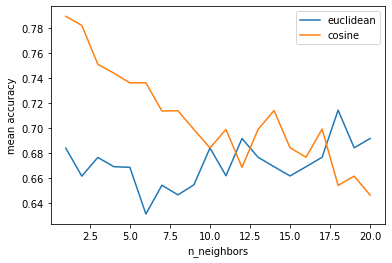

In [152]:
plt.plot(np.arange(20) + 1, [np.mean(x) for x in euclidean_score.values()])
plt.plot(np.arange(20) + 1, [np.mean(x) for x in cosine_score.values()])
plt.legend(['euclidean', 'cosine'])
plt.xlabel('n_neighbors')
plt.ylabel('mean accuracy')
plt.show()

Косинусное расстояние дает более приличный результат, чем евклидова метрика для небольшого числа соседей (а большое число соседей нас скорее и не будет интересовать, так как оно даст не самый хороший результат). 

- Косинуское расстояние дает большую точность, скорее всего, потому, что оно отражает относительное, а не абсолютное сравнение размеров отдельных векторов. Таким образом, эта мера наиболее подходит для данных, где частота важнее абсолютных значений.

Скачаем и импортируем `mlxtend` -- библиотеку для упрощенной реализации решающих поверхностей обученных классификаторов.

In [21]:
!pip install mlxtend

In [22]:
import mlxtend

In [23]:
# Это для встроенного KNN
from sklearn.neighbors import KNeighborsClassifier

neighbours = [1, 3, 5, 10, 15, 25]
TrainedClassifiers = []
print('NN\tTrain\tTest')
for k in neighbours:
    print(k, end = '\t')
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_newTrain, Y_train)
    TrainedClassifiers.append(clf) # для подсказки 5 из задачи 1.5
    for X_data, y_data in zip([X_newTrain, X_newTest], [Y_train, Y_test]):
        y_predicted = clf.predict(X_data)
        print(f"{np.mean(y_predicted==y_data):.2f}", end = '\t')
    print('')

NN	Train	Test
1	1.00	0.60	
3	0.79	0.73	
5	0.77	0.73	
10	0.74	0.80	
15	0.73	0.80	
25	0.71	0.78	


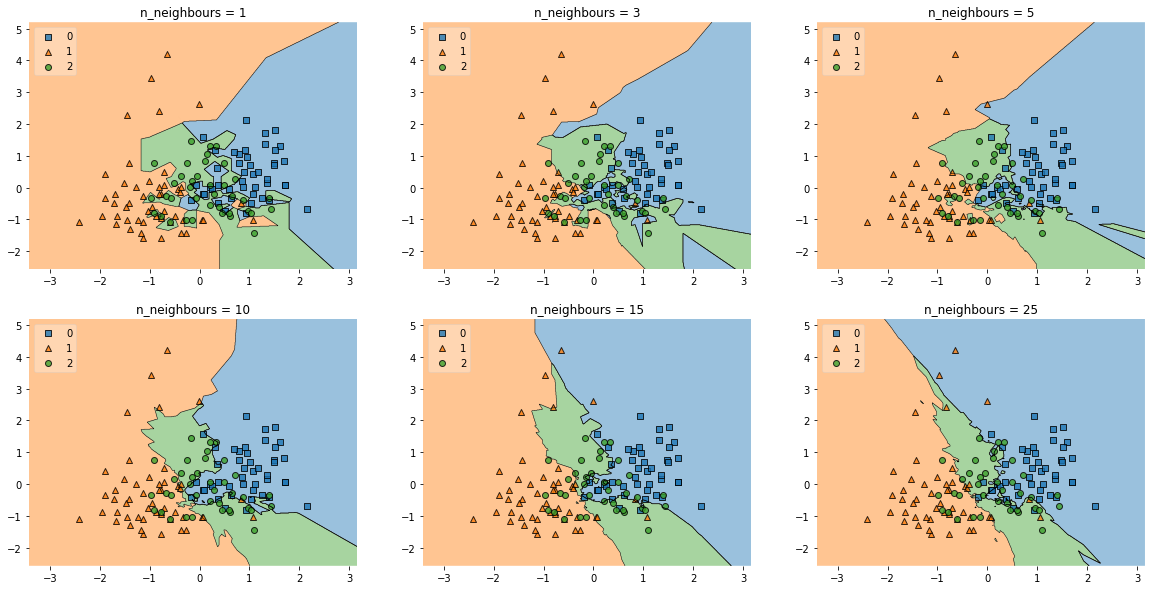

In [ ]:
from mlxtend.plotting import plot_decision_regions
from itertools import product

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))

for classifier, a in zip(TrainedClassifiers, product([0, 1], [0, 1, 2])):
    ax = axs[a[0], a[1]]
    plot_decision_regions(np.array(X_newTrain), np.array(Y_train), clf=classifier, legend=2, ax=ax)
    ax.set_title('n_neighbours = ' + str(neighbours[3 * a[0] + a[1]]))
plt.show()

Самая высокая точность предсказания на тестовой выборке оказалсь для десяти соседей. Для этого числа получилось самое разумное соотношение точности на тренировочной и тестовой выборках. Для меньших значений нашего гиперпараметра (числа соседей) выходила высокая точность на тренировочной выборке, что может судить о переобучении модели -> низкая точность предсказания на тестовой выборке. При больших значениях числа соседей результат тоже не очень хороший, так как, на самом деле, у нас не так много данных (всего 178) и большое количество соседей, на которых мы смотрим, может сбивать наше предсказние: вдруг рядом с нашей точкой находится 5 зеленых точек (очень близко), тогда бы мы хотели сказать, что наше предсказание -- зеленый, но мы смотрим на 25 соседей, а не на пять, и может окзаться так, что подальше от рассматриваемой точки мы найдем скопление из 20 синих точек. Тогда нам придется раскрасить рассматриваемую точку в синий цвет. Проблема в том, что соседи дают одинаковый вклад в результат, вне зависимости от расстояния. Если уж мы хотим брать большое число соседей, то нужно уменьшать вклад от далеких точек и увеличиват от близких (например, ввести функцию, которая большая при маленьких значения расстояния и маленькая при больших значениях расстояния: что-то типо  𝑒−𝑟2 , и использовать ее как вескаждой точки относительно рассмариваемой).

Касательно картинок: признак хорошего классификатора -- это отсутствие непонятных крошечных островков иного цвета, гладкость границ областей и остуствие узких зон. Смотря на распределние данных, хочется сказать, что посередине хотелось бы увидеть зеленое пятно, слева и слева-сверху должны быть оранжевые зоны, а в остальных местах -- синие. Самые гладкие и приятные на взгляд границы получились для 25 соседей, но при этом мы видим явную несправедливость по отношению к зеленому цвету в центре картинки, а также хотелось бы, чтобы слева-сверху все-таки была оранжевая зона, а не синяя. Под наибольшее количество вышеупомянутых мной критериев, на мой взгляд, попадает картинка для десяти соседей. Единственная ее проблема в том, что нижний правый угол зеленый, а хотелось бы видеть его синим.

- Хороший результат при $k = 10$ довольно логичен -- при большом числе соседей мы можем учитывать элементы из другого цвета, т.е. для прогнозирования при большем $k$ учитывается больше разнородных экземпляров, что усложняет прогнозирование. При этом, для малых $k$ решающая поверхность не гладкая 

# Сравним со встроенным KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
neighbours = [1, 3, 5, 10, 15, 25]
TrainedClassifiers = []
print('NN\tTrain\tTest')
for k in neighbours:
    print(k, end = '\t')
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_newTrain, Y_train)
    TrainedClassifiers.append(clf) 
    for X_data, y_data in zip([X_newTrain, X_newTest], [Y_train, Y_test]):
        y_predicted = clf.predict(X_data)
        print(f"{np.mean(y_predicted==y_data):.2f}", end = '\t')
    print('')

NN	Train	Test
1	1.00	0.60	
3	0.79	0.73	
5	0.77	0.73	
10	0.74	0.80	
15	0.73	0.80	
25	0.71	0.78	


Получаем ровно те же результаты, что и были у нас для реализованного нами KNN

## Теперь сравним KNN с более сложной моделью - RandomForest

In [82]:
from mlxtend.data import boston_housing_data
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [83]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# TODO: обучите решающее дерево без ограничений на тренировочной выборке
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# TODO: рассчитайте MSE на тренировочной и тестовой выборках
print('MSE_train: %f' % mean_squared_error(y_train, dt.predict(X_train)))
print('MSE_test: %f' % mean_squared_error(y_test, dt.predict(X_test)))

MSE_train: 0.000000
MSE_test: 18.847303


In [84]:
# переобучена, так как нет ограничений

In [85]:
from sklearn.ensemble import RandomForestRegressor

base_tree = DecisionTreeRegressor(random_state = 123)

# Обучим случайный лес с 20 деревьями, каждое из которых строится без ограничений
rf = RandomForestRegressor(n_estimators = 20)
# Рассчитаем MSE на тренировочной и тестовой выборках для случайного леса
rf.fit(X_train, y_train)
print('MSE_train: %f' % mean_squared_error(y_train, rf.predict(X_train)))
print('MSE_test: %f' % mean_squared_error(y_test, rf.predict(X_test)))

MSE_train: 1.707529
MSE_test: 15.650232


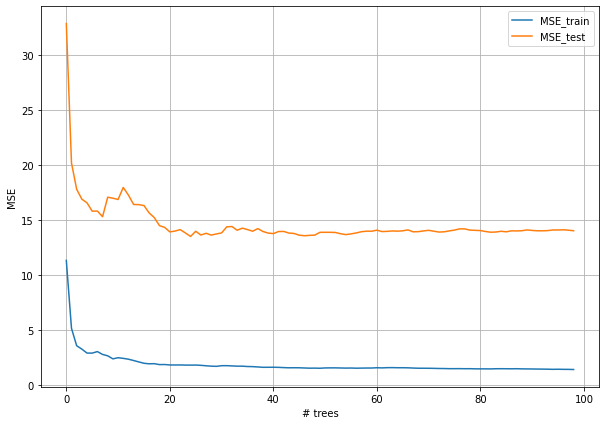

In [29]:
# Построим зависимость MSE от количества деревьев
n_trees = 100
train_loss = []
test_loss = []

for i in range(1, n_trees):
    rf = RandomForestRegressor(n_estimators = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('# trees')
plt.legend();

Как и ожидалось, по достижении некоторого числа деревьев обе ошибки практически не изменяются, то есть переобучения при росте числа деревьев не происходит.

Однако обычно при изменении какого-нибудь другого параметра на реальных данных переобучение может произойти. Например, случайный лес с ограниченными по глубине деревьями может предсказывать более точно, чем лес без ограничений.

В нашем же случае случайный лес, скорее, лишь страдает от регуляризации. Например, посмотрим на поведение модели при изменении максимальной глубины деревьев.

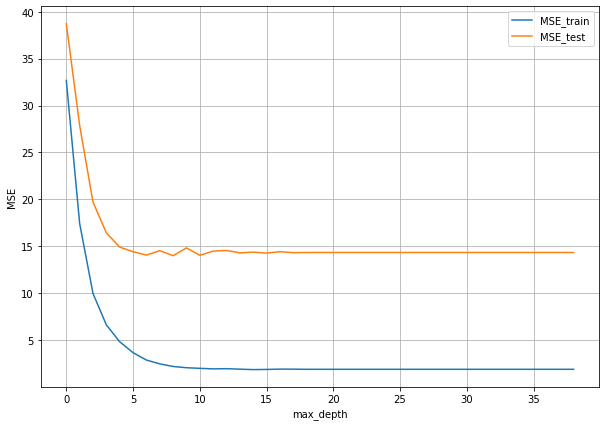

In [30]:
# От максимальной глубина
max_depth = 40
train_loss = []
test_loss = []

for i in range(1, max_depth):
    rf = RandomForestRegressor(n_estimators = 20, max_depth = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('max_depth')
plt.legend();

In [31]:
# Переобучение не наблюдается. Вообще же, как обычно, гиперпараметры случайного леса стоит подбирать на кросс-валидации

In [46]:
# Раз уж зашел разговор про деревья, то есть одна интересная вещь, на которую можно посмотреть: как отбирать признаки
# по важности на основе обучения дерева: чем больше разбиений происходило по конкретному признаку, тем более он важен

In [49]:
# Просто чтобы подгрузить названия признаков
from sklearn.datasets import load_boston
data = load_boston()

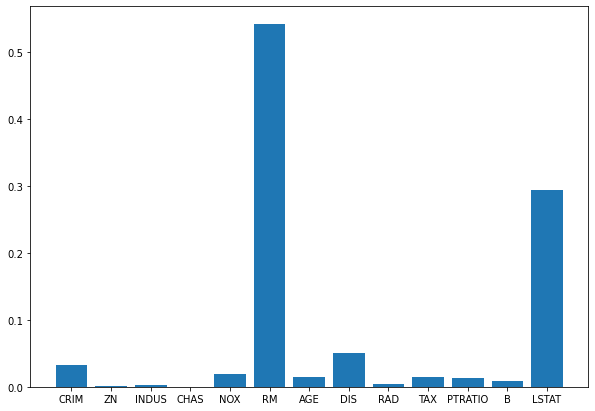

In [50]:
plt.figure(figsize = (10, 7))
plt.bar(data['feature_names'], rf.feature_importances_);

In [ ]:
# Посмотреть что это за признаки!

In [86]:
from sklearn.neighbors import KNeighborsRegressor

In [89]:
# Для деревьев абсолютно не важна нормализация, а вот для метрических методов важна

In [108]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(data=sc.fit_transform(X_train), columns=data['feature_names'])
X_test_scaled = pd.DataFrame(data=sc.transform(X_test), columns=data['feature_names'])

In [99]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)

In [100]:
knn_regressor.fit(X_train_scaled, y_train)
print('MSE_train: %f' % mean_squared_error(y_train, knn_regressor.predict(X_train_scaled)))
print('MSE_test: %f' % mean_squared_error(y_test, knn_regressor.predict(X_test_scaled)))

MSE_train: 11.870850
MSE_test: 29.786682


In [92]:
# Подберем оптимальное количество соседей

In [93]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train_scaled, y_train, 
                                                                          test_size = 0.3, random_state = 123)

In [94]:
errors = []
K = 25
for k in range(1, K):
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_train, y_train_train)
    errors.append(mean_squared_error(y_train_val, knn_regressor.predict(X_train_val)))

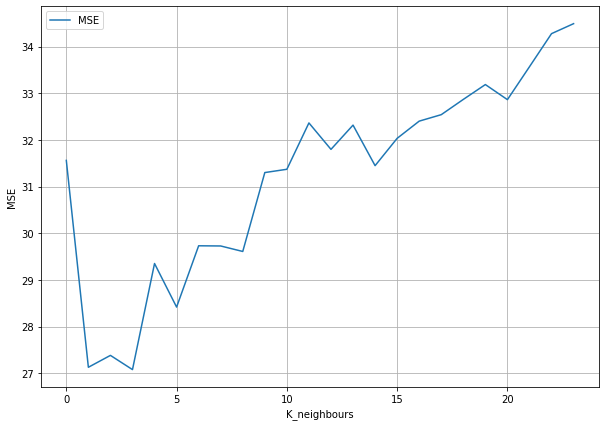

In [95]:
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(errors, label = 'MSE')
plt.ylabel('MSE')
plt.xlabel('K_neighbours')
plt.legend();

In [96]:
k = np.array(errors).argmin()
k

3

In [98]:
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train_scaled, y_train)
print('MSE_train: %f' % mean_squared_error(y_train, knn_regressor.predict(X_train_scaled)))
print('MSE_test: %f' % mean_squared_error(y_test, knn_regressor.predict(X_test_scaled)))

MSE_train: 7.785035
MSE_test: 30.768765


In [51]:
# Все равно имеем результаты гораздо хуже, что логично - Knn довольно простая модель, обучения нет (мы просто запоминаем 
# выборку и все)

In [52]:
# Интересно еще взгянуть на линейные модели, вдруг наша выборка хорошо линеаизуется

In [101]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [102]:
lr = LinearRegression().fit(X_train_scaled, y_train)
print ("Train: {}".format(mean_squared_error(y_train, lr.predict(X_train_scaled))))
print ("Test: {}".format(mean_squared_error(y_test, lr.predict(X_test_scaled))))

Train: 20.184336639873152
Test: 28.40585481050823


In [103]:
# Все еще хуже деревьев, но лучше knn - тут явно меньше переобучения, так как разница между ошибкой на 
# трейне и на тесте не очень большая, в отличие от knn
# Попробуем еще с регуляризацией (штраф за большие веса, контролирует переобучение)

In [104]:
# Текущие коэффициенты
lr.coef_

array([-0.9281326 ,  0.91733243,  0.51483834,  0.062497  , -1.6306264 ,
        3.42029822, -0.2106865 , -2.81921261,  2.3080726 , -2.16656895,
       -2.03787778,  0.5639928 , -3.50931538])

In [111]:
ridge = Ridge(5).fit(X_train_scaled, y_train)
print ("Train: {}".format(mean_squared_error(y_train, ridge.predict(X_train_scaled))))
print ("Test: {}".format(mean_squared_error(y_test, ridge.predict(X_test_scaled))))
ridge.coef_

Train: 20.219032310493024
Test: 28.501890807630843


array([-0.88643584,  0.84339886,  0.34140132,  0.08557826, -1.46879005,
        3.44383186, -0.22434407, -2.66025749,  1.93535732, -1.80606628,
       -1.9928976 ,  0.55865734, -3.43407108])

In [112]:
# Чуть хуже, но видим, что коэффициенты значительно уменьшились

In [113]:
lasso = Lasso(5).fit(X_train_scaled, y_train)
print ("Train: {}".format(mean_squared_error(y_train, lasso.predict(X_train_scaled))))
print ("Test: {}".format(mean_squared_error(y_test, lasso.predict(X_test_scaled))))
lasso.coef_

Train: 58.023199180694185
Test: 59.01130233276887


array([-0.        ,  0.        , -0.        ,  0.        , -0.        ,
        1.18360119, -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -1.15201046])

In [114]:
# Лассо в свойственной себе манере сильно занулил все веса при признаках, которая эта модель посчитала наименее важными
# Взглянем на важность признаков с точки зрения Lasso:

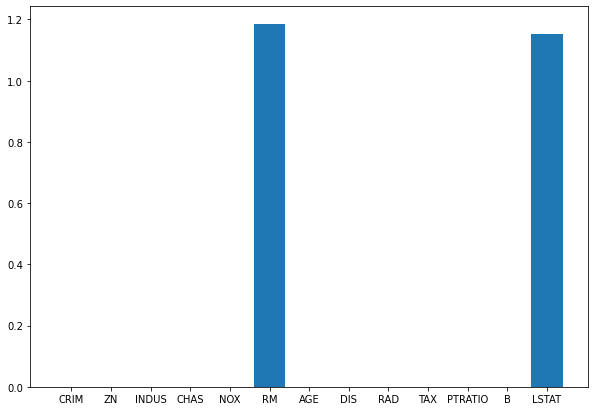

In [115]:
plt.figure(figsize = (10, 7))
plt.bar(data['feature_names'], abs(lasso.coef_));

In [116]:
# Заметим, что эта модель посчитала важными очти те же признаки, что и деревья - лидеры RM и LSTAT

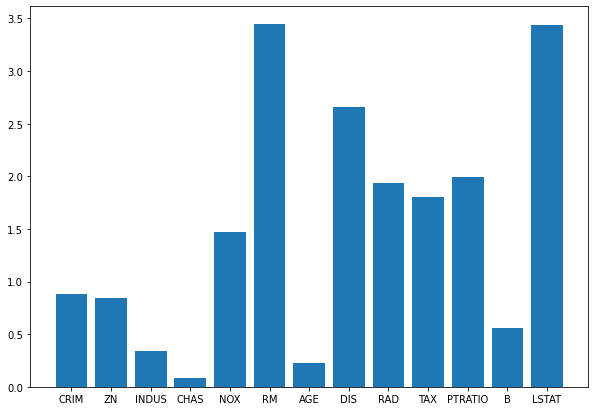

In [117]:
plt.figure(figsize = (10, 7))
plt.bar(data['feature_names'], abs(ridge.coef_));

In [118]:
# А вот Ridge не такой агрессивный, но лидеры те же

C:\Users\73F5~1\AppData\Local\Temp/ipykernel_13464/2017180419.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso = Lasso(a).fit(X_train, y_train)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3572.6275852575523, tolerance: 3.0368595169491526
  model = cd_fast.enet_coordinate_descent(


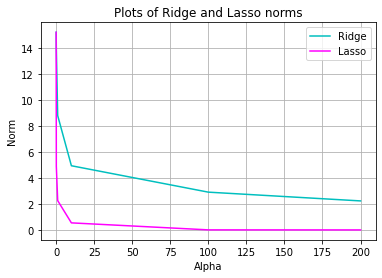

In [119]:
alpha = [0, 0.1, 1, 10, 100, 200]
ridge_graph = []
lasso_graph = []
for a in alpha:
    ridge = Ridge(a).fit(X_train, y_train)
    norm1 = np.linalg.norm(ridge.coef_)
    ridge_graph.append(norm1)
    lasso = Lasso(a).fit(X_train, y_train)
    norm2 = np.linalg.norm(lasso.coef_)
    lasso_graph.append(norm2)

x = np.array(alpha)
y = np.array(ridge_graph)
z = np.array(lasso_graph)

plt.plot(x, y, 'c', linestyle = '-')
plt.plot(x, z, 'magenta', linestyle = '-')
plt.xlabel("Alpha")
plt.ylabel("Norm") 
plt.title("Plots of Ridge and Lasso norms")
plt.legend(['Ridge', 'Lasso'])
plt.grid()
plt.show()

In [120]:
# из графика видно, что Lasso агрессивнее уменьшает веса

In [121]:
# для Lasso-регрессии свойсвенна следующая картина: коэффициенты пропорциональны важности соответствующих признаков. Тогда
# менее значимые переменные будут давать маленький вклад, так как коэффициенты при них будут почти нулевыми, а более значимые
# признаки будут существенно влиять на предсказание. Как итог у нас будет некий отбор признаков.

In [122]:
from sklearn.linear_model import LassoCV

reg = LassoCV(cv=5, alphas = [0.1, 1, 10, 100, 200]).fit(X_train_scaled, y_train)
print(reg.alphas_) # в обратном порядке вывелось
reg.mse_path_

[2.e+02 1.e+02 1.e+01 1.e+00 1.e-01]


array([[81.14515081, 96.08624275, 94.32636302, 87.23331912, 72.08416428],
       [81.14515081, 96.08624275, 94.32636302, 87.23331912, 72.08416428],
       [81.14515081, 96.08624275, 94.32636302, 87.23331912, 72.08416428],
       [21.50399272, 32.99630906, 23.03885629, 32.01179017, 22.68778929],
       [16.37767041, 29.37361658, 19.33025365, 29.51333935, 21.072129  ]])

In [123]:
np.array(list(map(lambda x: np.mean(x), reg.mse_path_)))

array([86.175048  , 86.175048  , 86.175048  , 26.44774751, 23.1334018 ])

In [124]:
# итого оптимальный вариант - последний, то есть для alpha = 0.1

In [125]:
lasso = Lasso(1).fit(X_train_scaled,y_train)
print ("Train: {}".format(mean_squared_error(y_train, lasso.predict(X_train_scaled))))
print ("Test: {}".format(mean_squared_error(y_test, lasso.predict(X_test_scaled))))
lasso.coef_

Train: 25.30291492027384
Test: 35.51098770160136


array([-0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  3.34690914e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -1.76517845e-03, -1.37411953e+00,  0.00000000e+00,
       -3.29454265e+00])

In [126]:
# Вообще хуже, чем без регуляризации...